# Libraries importing

In [360]:
import csv
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [361]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score


In [362]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape

# Data loading

In [363]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv")

#df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Engineering

In [364]:
def add_all_time_features(df, datetime_col='DateTime', target_col='Bjelave_PM10'):
    df_dt=df.copy()
    df_dt['Day'] = df[datetime_col].dt.day.astype(np.float64)               # 1.0, 2.0, ..., 31.0
    df_dt['Month'] = df[datetime_col].dt.month.astype(np.float64)           # 1.0, 2.0, ..., 12.0
    df_dt['Year'] = df[datetime_col].dt.year.astype(np.float64)
    #df['Week_of_Year'] = df[datetime_col].dt.isocalendar().week.astype(np.float64) # 1.0, ..., 52.0
    return df_dt

In [365]:
df_processed_combined_data_daily_dt = add_all_time_features(
    df=df_processed_combined_data_daily
)

In [366]:
df_processed_combined_data_daily_dt.shape

(1826, 15)

In [367]:
df_processed_combined_data_daily.shape

(1826, 12)

# Dataset Splitting

In [368]:
import matplotlib.pyplot as plt
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [369]:
def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [370]:
df_processed_combined_data_daily

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
0,2018-01-01,1.876859,188.675592,0.012500,940.004167,3.316667,83.500000,17358.823529,7.117647,51.293265,20.956605,34.174856
1,2018-01-02,1.876859,188.675592,0.495833,936.579167,3.541667,93.041667,11216.666667,8.000000,51.293265,27.324796,37.907709
2,2018-01-03,1.876859,188.675592,0.187500,937.400000,3.237500,77.541667,12737.500000,7.112500,61.345475,19.669382,30.834321
3,2018-01-04,1.876859,188.675592,0.000000,935.770833,1.304167,91.500000,11312.500000,6.233333,41.241054,21.401833,31.298637
4,2018-01-05,1.876859,188.675592,0.000000,937.583333,5.183333,74.416667,18941.666667,5.520833,44.815521,20.001500,31.914025
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-12-27,2.029167,125.375000,0.479167,948.729167,7.879167,79.666667,18579.166667,6.358333,26.714598,22.752038,26.175499
1822,2022-12-28,1.450000,179.125000,0.000000,949.583333,4.591667,82.208333,19416.666667,4.937500,29.372987,23.098171,32.184576
1823,2022-12-29,2.187500,146.166667,0.000000,947.341667,5.354167,81.666667,18812.500000,4.187500,50.187371,25.431842,38.493039
1824,2022-12-30,1.070833,159.541667,0.000000,947.279167,6.429167,79.083333,19416.666667,4.000000,67.841704,27.591008,54.974991


In [371]:
#input window = 7
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=2*7+ int(7/5 + 1))
train_data_combined_ws_week, test_data_combined_ws_week = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_week, test_PM10_daily_ws_week = train_test_split(df_PM10_daily, date)

train_data_combined_ws_week_dt, test_data_combined_ws_week_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 15 #i isti look back
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=2*15+ int(15/5 + 1))
train_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen = train_test_split(df_PM10_daily, date)

train_data_combined_ws_fifteen_dt, test_data_combined_ws_fifteen_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 30
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=2*30+ int(30/5 + 1))
train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 60
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=2*60+ int(60/5 + 1))
train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date)
train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 90
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=2*90+ int(90/6 + 1))
train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily, date)
train_PM10_daily_ws_ninety, test_PM10_daily_ws_ninety = train_test_split(df_PM10_daily, date)
train_data_combined_ws_ninety_dt, test_data_combined_ws_ninety_dt = train_test_split(df_processed_combined_data_daily_dt, date) #


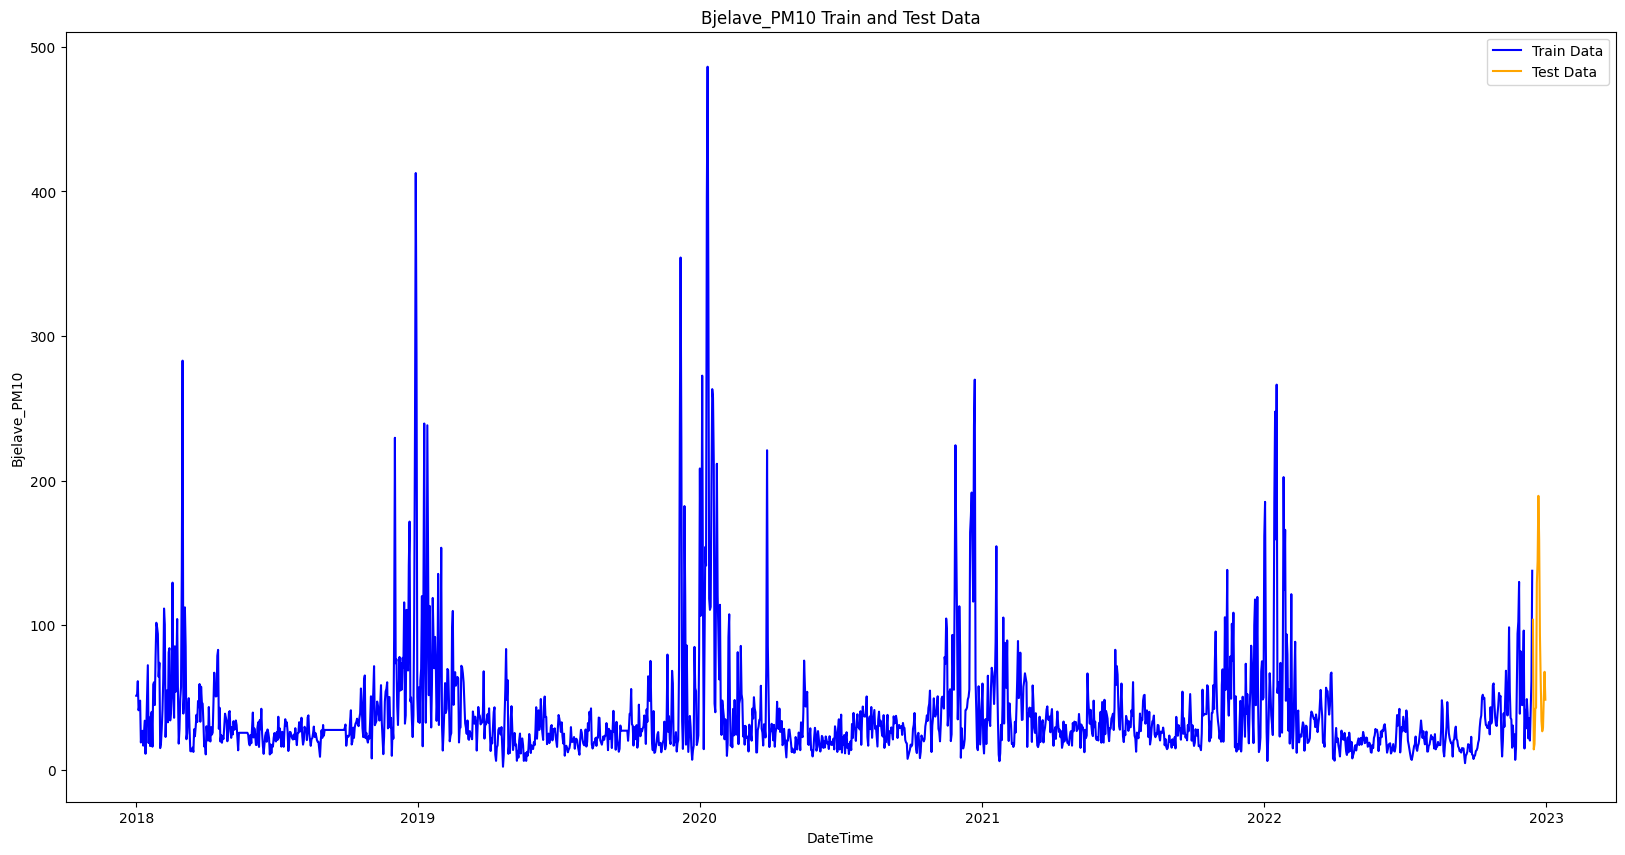

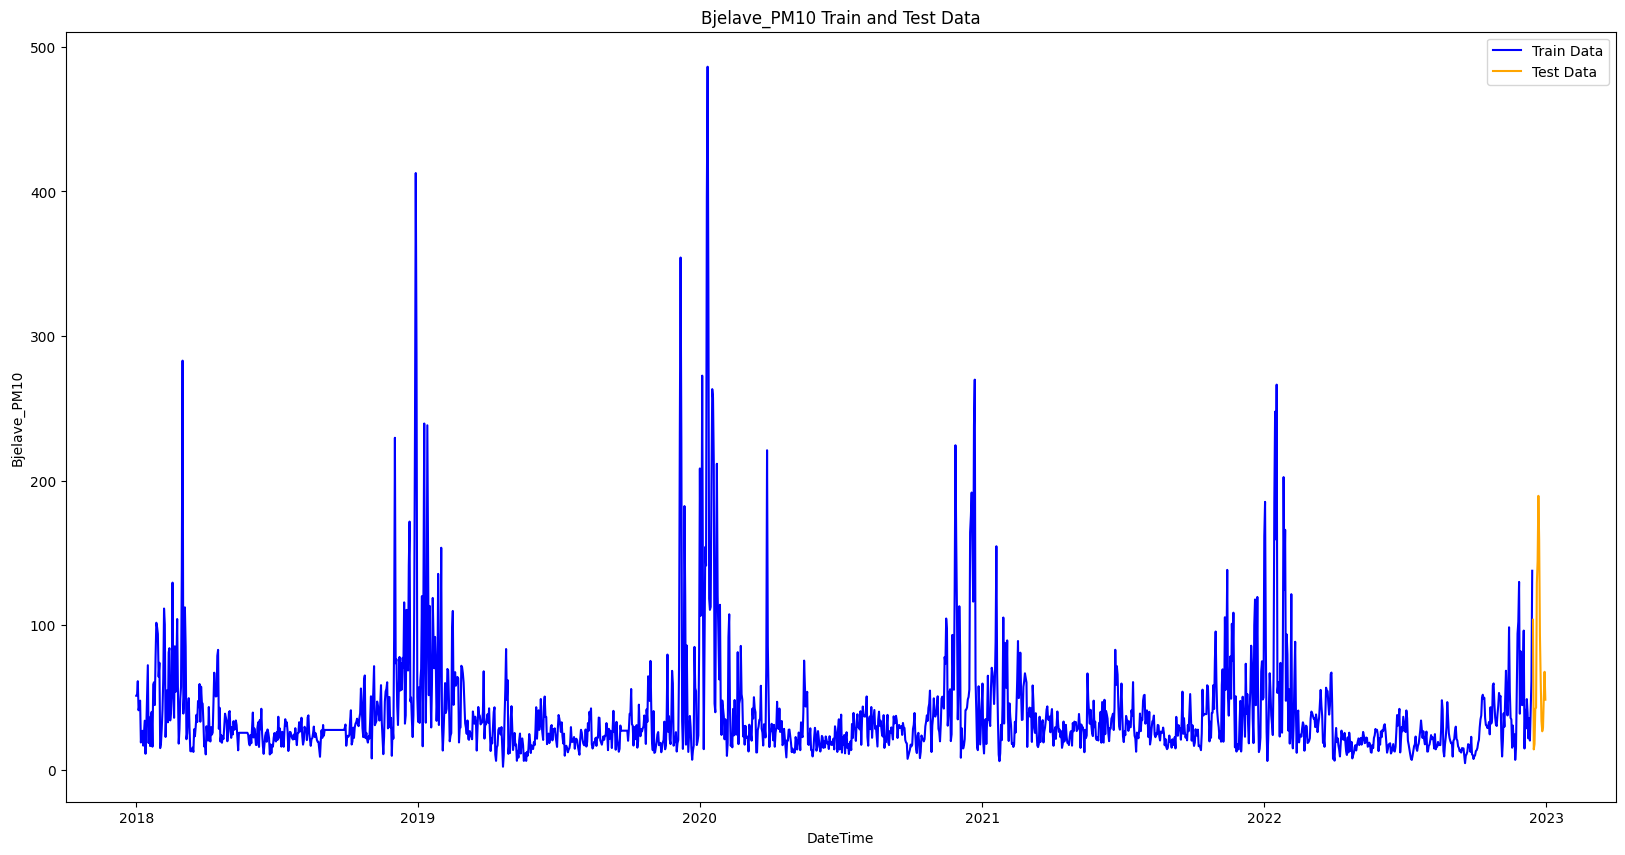

In [372]:
plot_train_test_data(train_data_combined_ws_week, test_data_combined_ws_week, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_week, test_PM10_daily_ws_week, 'DateTime', 'Bjelave_PM10')

# Dataset Scaling

In [373]:
from sklearn.preprocessing import MinMaxScaler

train_data_combined_ws_week = train_data_combined_ws_week.set_index('DateTime')
test_data_combined_ws_week = test_data_combined_ws_week.set_index('DateTime')

scaler_data_combined_ws_week = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_week_scaled = scaler_data_combined_ws_week.fit_transform(train_data_combined_ws_week)
test_data_combined_ws_week_scaled = scaler_data_combined_ws_week.transform(test_data_combined_ws_week)


In [374]:
train_data_combined_ws_week_dt = train_data_combined_ws_week_dt.set_index('DateTime')
test_data_combined_ws_week_dt = test_data_combined_ws_week_dt.set_index('DateTime')

scaler_data_combined_ws_week_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_week_scaled_dt = scaler_data_combined_ws_week_dt.fit_transform(train_data_combined_ws_week_dt)
test_data_combined_ws_week_scaled_dt = scaler_data_combined_ws_week_dt.transform(test_data_combined_ws_week_dt)


In [375]:
print(test_data_combined_ws_week.columns.get_loc('Bjelave_PM10'))
index_of_target_feature=test_data_combined_ws_week.columns.get_loc('Bjelave_PM10')
print(test_data_combined_ws_week.columns)

8
Index(['wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10',
       'Bjelave_SO2', 'Bjelave_NO2'],
      dtype='object')


In [376]:
test_data_combined_ws_week.shape

(17, 11)

In [377]:
train_data_combined_ws_fifteen_dt = train_data_combined_ws_fifteen_dt.set_index('DateTime')
test_data_combined_ws_fifteen_dt = test_data_combined_ws_fifteen_dt.set_index('DateTime')

scaler_data_combined_ws_fifteen_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_fifteen_scaled_dt = scaler_data_combined_ws_fifteen_dt.fit_transform(train_data_combined_ws_fifteen_dt)
test_data_combined_ws_fifteen_scaled_dt = scaler_data_combined_ws_fifteen_dt.transform(test_data_combined_ws_fifteen_dt)

In [378]:
train_data_combined_ws_fifteen = train_data_combined_ws_fifteen.set_index('DateTime')
test_data_combined_ws_fifteen = test_data_combined_ws_fifteen.set_index('DateTime')

scaler_data_combined_ws_fifteen = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_fifteen_scaled = scaler_data_combined_ws_fifteen.fit_transform(train_data_combined_ws_fifteen)
test_data_combined_ws_fifteen_scaled = scaler_data_combined_ws_fifteen.transform(test_data_combined_ws_fifteen)

In [379]:
train_data_combined_ws_thirty_dt = train_data_combined_ws_thirty_dt.set_index('DateTime')
test_data_combined_ws_thirty_dt = test_data_combined_ws_thirty_dt.set_index('DateTime')

scaler_data_combined_ws_thirty_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_thirty_scaled_dt = scaler_data_combined_ws_thirty_dt.fit_transform(train_data_combined_ws_thirty_dt)
test_data_combined_ws_thirty_scaled_dt = scaler_data_combined_ws_thirty_dt.transform(test_data_combined_ws_thirty_dt)

In [380]:
train_data_combined_ws_thirty = train_data_combined_ws_thirty.set_index('DateTime')
test_data_combined_ws_thirty = test_data_combined_ws_thirty.set_index('DateTime')

scaler_data_combined_ws_thirty = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_thirty_scaled = scaler_data_combined_ws_thirty.fit_transform(train_data_combined_ws_thirty)
test_data_combined_ws_thirty_scaled = scaler_data_combined_ws_thirty.transform(test_data_combined_ws_thirty)

In [381]:
train_data_combined_ws_sixty_dt = train_data_combined_ws_sixty_dt.set_index('DateTime')
test_data_combined_ws_sixty_dt = test_data_combined_ws_sixty_dt.set_index('DateTime')

scaler_data_combined_ws_sixty_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_sixty_scaled_dt = scaler_data_combined_ws_sixty_dt.fit_transform(train_data_combined_ws_sixty_dt)
test_data_combined_ws_sixty_scaled_dt = scaler_data_combined_ws_sixty_dt.transform(test_data_combined_ws_sixty_dt)

In [382]:
train_data_combined_ws_sixty = train_data_combined_ws_sixty.set_index('DateTime')
test_data_combined_ws_sixty = test_data_combined_ws_sixty.set_index('DateTime')

scaler_data_combined_ws_sixty = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_sixty_scaled = scaler_data_combined_ws_sixty.fit_transform(train_data_combined_ws_sixty)
test_data_combined_ws_sixty_scaled = scaler_data_combined_ws_sixty.transform(test_data_combined_ws_sixty)

print("train_data_combined_ws_sixty_scaled.shape :", train_data_combined_ws_sixty_scaled.shape)
print("train_data_combined_ws_sixty.shape :", train_data_combined_ws_sixty.shape)

print("test_data_combined_ws_sixty_scaled.shape :", test_data_combined_ws_sixty_scaled.shape)
print("test_data_combined_ws_sixty.shape :", test_data_combined_ws_sixty.shape)

train_data_combined_ws_sixty_scaled.shape : (1692, 11)
train_data_combined_ws_sixty.shape : (1692, 11)
test_data_combined_ws_sixty_scaled.shape : (134, 11)
test_data_combined_ws_sixty.shape : (134, 11)


In [383]:
train_data_combined_ws_ninety = train_PM10_daily_ws_ninety.set_index('DateTime')
test_data_combined_ws_ninety = test_PM10_daily_ws_ninety.set_index('DateTime')

scaler_data_combined_ws_ninety = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_ninety_scaled = scaler_data_combined_ws_ninety.fit_transform(train_data_combined_ws_ninety)
test_data_combined_ws_ninety_scaled = scaler_data_combined_ws_ninety.transform(test_data_combined_ws_ninety)

In [384]:
train_PM10_daily_ws_week = train_PM10_daily_ws_week.set_index('DateTime')
test_PM10_daily_ws_week = test_PM10_daily_ws_week.set_index('DateTime')

scaler_PM10_daily_ws_week = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_week = scaler_PM10_daily_ws_week.fit_transform(train_PM10_daily_ws_week)
test_PM10_daily_ws_week = scaler_PM10_daily_ws_week.transform(test_PM10_daily_ws_week)

In [385]:
train_PM10_daily_ws_fifteen = train_PM10_daily_ws_fifteen.set_index('DateTime')
test_PM10_daily_ws_fifteen = test_PM10_daily_ws_fifteen.set_index('DateTime')

scaler_PM10_daily_ws_fifteen = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.fit_transform(train_PM10_daily_ws_fifteen)
test_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.transform(test_PM10_daily_ws_fifteen)

In [386]:
train_PM10_daily_ws_thirty = train_PM10_daily_ws_thirty.set_index('DateTime')
test_PM10_daily_ws_thirty = test_PM10_daily_ws_thirty.set_index('DateTime')

scaler_PM10_daily_ws_thirty = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.fit_transform(train_PM10_daily_ws_thirty)
test_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.transform(test_PM10_daily_ws_thirty)

In [387]:
train_PM10_daily_ws_sixty = train_PM10_daily_ws_sixty.set_index('DateTime')
test_PM10_daily_ws_sixty = test_PM10_daily_ws_sixty.set_index('DateTime')

scaler_PM10_daily_ws_sixty = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.fit_transform(train_PM10_daily_ws_sixty)
test_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.transform(test_PM10_daily_ws_sixty)

In [388]:
train_PM10_daily_ws_ninety = train_PM10_daily_ws_ninety.set_index('DateTime')
test_PM10_daily_ws_ninety = test_PM10_daily_ws_ninety.set_index('DateTime')

scaler_PM10_daily_ws_ninety = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_ninety = scaler_PM10_daily_ws_ninety.fit_transform(train_PM10_daily_ws_ninety)
test_PM10_daily_ws_ninety = scaler_PM10_daily_ws_ninety.transform(test_PM10_daily_ws_ninety)

In [389]:
train_data_combined_ws_ninety_dt = train_data_combined_ws_ninety_dt.set_index('DateTime')
test_data_combined_ws_ninety_dt = test_data_combined_ws_ninety_dt.set_index('DateTime')

scaler_data_combined_ws_ninety_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_ninety_scaled_dt = scaler_data_combined_ws_ninety_dt.fit_transform(train_data_combined_ws_ninety_dt)
test_data_combined_ws_ninety_scaled_dt = scaler_data_combined_ws_ninety_dt.transform(test_data_combined_ws_ninety_dt)

# LSTM for Univariate Time Series Prediction

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    """
    Create LSTM dataset by splitting the input data into input sequences (X) and corresponding output values (Y).

    Parameters:
    - data: numpy array, input data.
    - look_back: int, number of previous time steps to use as input variables to predict the next time period (default is 1).

    Returns:
    - X: numpy array, input sequences.
    - Y: numpy array, corresponding output values.
    """
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)

def train_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    # x_val = x_train[-50:]
    # y_val = y_train[-50:]
    # x_train = x_train[:-50]
    # y_train = y_train[:-50]
    # history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])
    history = model.fit(x_train, y_train, epochs=15, batch_size=5, verbose=1, callbacks=[early_stop])
    return history


In [ ]:

def build_model(look_back, num_features, params):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units2"], return_sequences=True))
	model.add(LSTM(units=params["lstm_units1"], return_sequences=False))
	model.add(Dense(1))
	model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model


In [ ]:
# Prepare input and output for LSTM model
look_back = 3
#x_train, y_train = create_dataset(train_data, look_back)

x_train_PM10_daily_ws_week, y_train_PM10_daily_ws_week = create_dataset(train_PM10_daily_ws_week, look_back)
x_train_PM10_daily_ws_fifteen, y_train_PM10_daily_ws_fifteen = create_dataset(train_PM10_daily_ws_fifteen, look_back)
x_train_PM10_daily_ws_thirty, y_train_PM10_daily_ws_thirty = create_dataset(train_PM10_daily_ws_thirty, look_back)
x_train_PM10_daily_ws_sixty, y_train_PM10_daily_ws_sixty = create_dataset(train_PM10_daily_ws_sixty, look_back)
x_train_PM10_daily_ws_ninety, y_train_PM10_daily_ws_ninety = create_dataset(train_PM10_daily_ws_ninety, look_back)

x_test_PM10_daily_ws_week, y_test_PM10_daily_ws_week = create_dataset(test_PM10_daily_ws_week, look_back)
x_test_PM10_daily_ws_fifteen, y_test_PM10_daily_ws_fifteen = create_dataset(test_PM10_daily_ws_fifteen, look_back)
x_test_PM10_daily_ws_thirty, y_test_PM10_daily_ws_thirty = create_dataset(test_PM10_daily_ws_thirty, look_back)
x_test_PM10_daily_ws_sixty, y_test_PM10_daily_ws_sixty = create_dataset(test_PM10_daily_ws_sixty, look_back)
x_test_PM10_daily_ws_ninety, y_test_PM10_daily_ws_ninety = create_dataset(test_PM10_daily_ws_ninety, look_back)

In [ ]:
x_train_PM10_daily_ws_thirty.shape

(1786, 3)

In [ ]:
# reshape input to be [samples, time steps, features]
#x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
num_features=1
x_train_PM10_daily_ws_week = np.reshape(x_train_PM10_daily_ws_week, (x_train_PM10_daily_ws_week.shape[0], look_back, num_features))
x_train_PM10_daily_ws_fifteen = np.reshape(x_train_PM10_daily_ws_fifteen, (x_train_PM10_daily_ws_fifteen.shape[0], look_back, num_features))
x_train_PM10_daily_ws_thirty = np.reshape(x_train_PM10_daily_ws_thirty, (x_train_PM10_daily_ws_thirty.shape[0], look_back, num_features))
x_train_PM10_daily_ws_sixty = np.reshape(x_train_PM10_daily_ws_sixty, (x_train_PM10_daily_ws_sixty.shape[0], look_back, num_features))
x_train_PM10_daily_ws_ninety = np.reshape(x_train_PM10_daily_ws_ninety, (x_train_PM10_daily_ws_ninety.shape[0], look_back, num_features))

x_test_PM10_daily_ws_week = np.reshape(x_test_PM10_daily_ws_week, (x_test_PM10_daily_ws_week.shape[0], look_back, num_features))
x_test_PM10_daily_ws_fifteen = np.reshape(x_test_PM10_daily_ws_fifteen, (x_test_PM10_daily_ws_fifteen.shape[0], look_back, num_features))
x_test_PM10_daily_ws_thirty = np.reshape(x_test_PM10_daily_ws_thirty, (x_test_PM10_daily_ws_thirty.shape[0], look_back, num_features))
x_test_PM10_daily_ws_sixty = np.reshape(x_test_PM10_daily_ws_sixty, (x_test_PM10_daily_ws_sixty.shape[0], look_back, num_features))
x_test_PM10_daily_ws_ninety = np.reshape(x_test_PM10_daily_ws_ninety, (x_test_PM10_daily_ws_ninety.shape[0], look_back, num_features))

In [ ]:
# Training the model
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
  "dropout": 0.1,
	"lstm_units": 64*2,
	"lstm_units3": 90,
	"lstm_units2": 85,
	"lstm_units1": 85,
	"lstm_units0": 40
}

In [ ]:
x_train_PM10_daily_ws_thirty.shape

(1786, 3, 1)

In [ ]:
y_train_PM10_daily_ws_thirty.shape

(1786,)

**7-Day Prediction Window**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0466 - root_mean_squared_error: 0.0796
Epoch 2/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0062 - mean_absolute_error: 0.0439 - root_mean_squared_error: 0.0784
Epoch 3/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0049 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0698
Epoch 4/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0667
Epoch 5/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0581
Epoch 6/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0625
Epoch 7/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0585
Epoch 8/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0041 - mean_

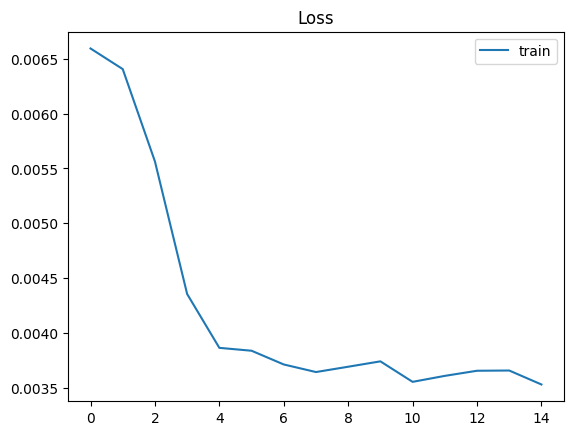

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_week, y_train_PM10_daily_ws_week)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_week_scaled = model.predict(x_test_PM10_daily_ws_week)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
testPredict_PM10_daily_ws_week = scaler_PM10_daily_ws_week.inverse_transform(testPredict_PM10_daily_ws_week_scaled)

In [ ]:
y_test_PM10_daily_ws_week_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(y_test_PM10_daily_ws_week.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week))
mae = mean_absolute_error(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week)
r2 = r2_score(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 34.413140395966394
MAE: 26.35880303272495
R2 Score: 0.6103518812710725


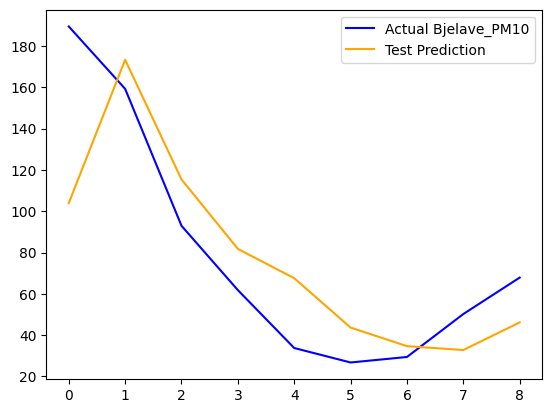

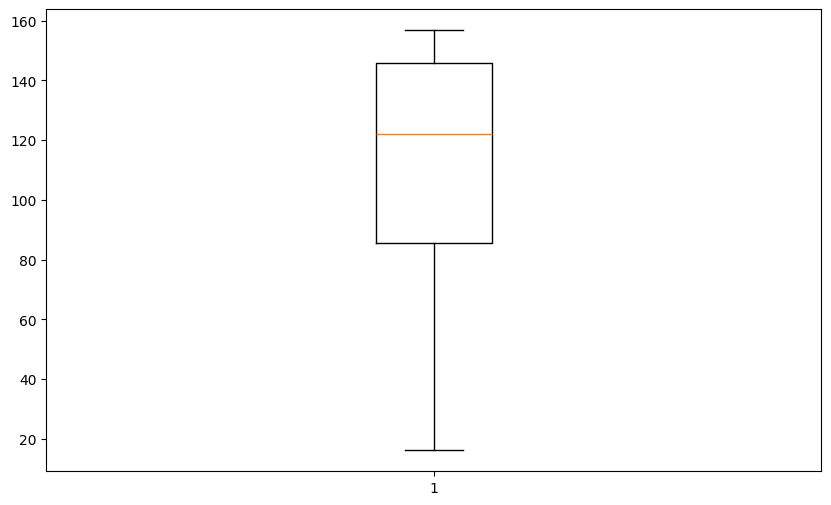

In [ ]:
plt.plot(y_test_PM10_daily_ws_week_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_week, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_week, y_test_PM10_daily_ws_week_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_week[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_week)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_week.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 63.35356062375965
MAE: 43.26995881729656
R2 Score: -0.32058398988986125


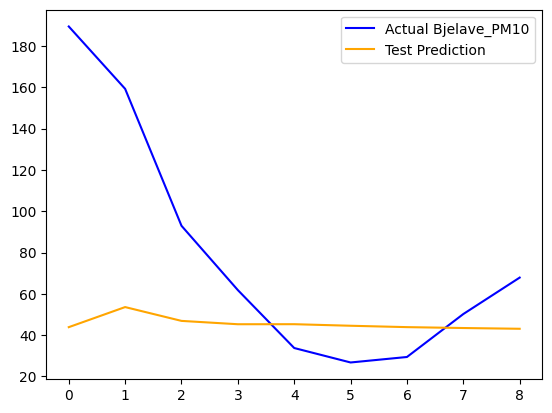

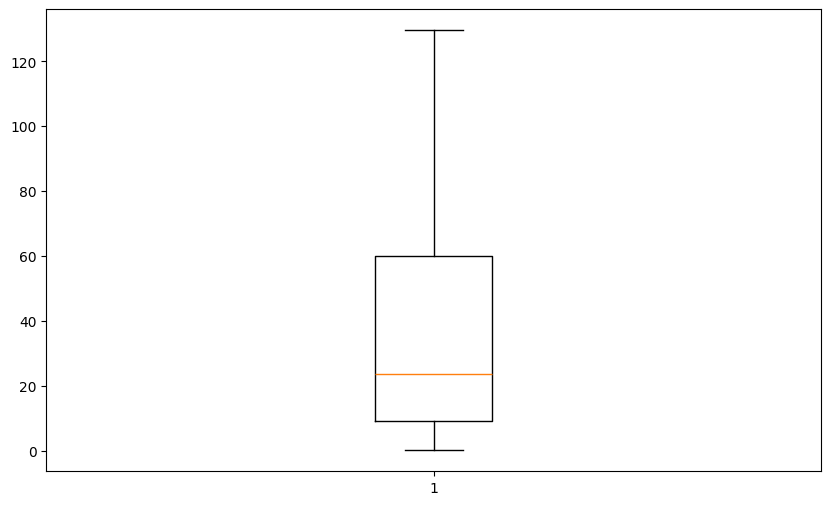

In [ ]:
plt.plot(y_test_PM10_daily_ws_week_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_week, walk_forward_predictions_unscaled[0])

**15-Day Prediction Window**

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0075 - mean_absolute_error: 0.0468 - root_mean_squared_error: 0.0852
Epoch 2/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0052 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0717
Epoch 3/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0066 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0812
Epoch 4/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0367 - root_mean_squared_error: 0.0674
Epoch 5/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0035 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0589
Epoch 6/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0586
Epoch 7/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0033 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0568
Epoch 8/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0043 - mean_absolute_er

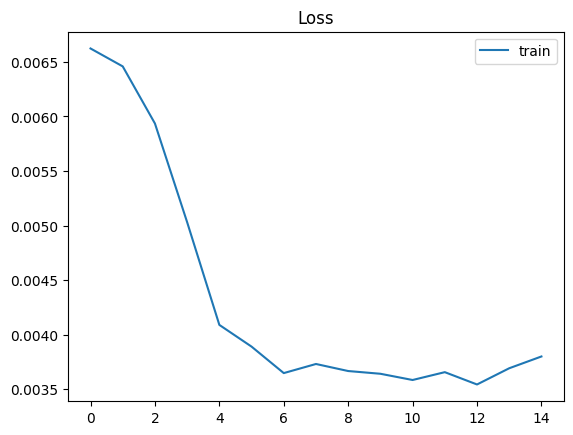

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_fifteen, y_train_PM10_daily_ws_fifteen)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_fifteen_scaled = model.predict(x_test_PM10_daily_ws_fifteen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


In [ ]:
testPredict_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.inverse_transform(testPredict_PM10_daily_ws_fifteen_scaled)

In [ ]:
y_test_PM10_daily_ws_fifteen_unscaled = scaler_PM10_daily_ws_fifteen.inverse_transform(y_test_PM10_daily_ws_fifteen.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen))
mae = mean_absolute_error(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen)
r2 = r2_score(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 43.76655514009207
MAE: 33.974882917699404
R2 Score: 0.33273123311098396


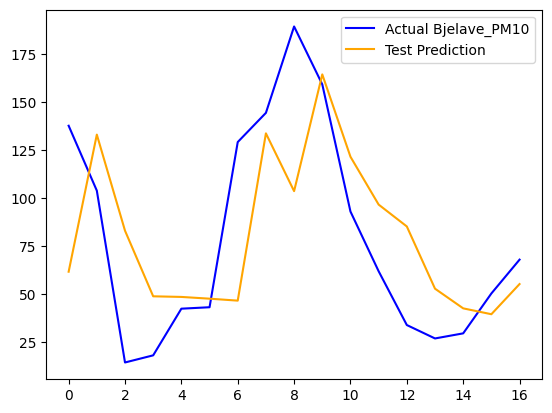

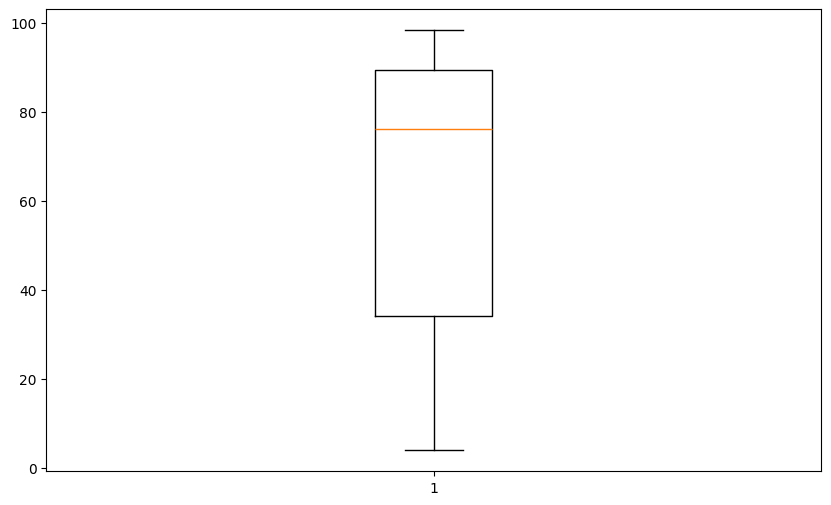

In [ ]:
plt.plot(y_test_PM10_daily_ws_fifteen_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_fifteen, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_fifteen, y_test_PM10_daily_ws_fifteen_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_fifteen[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_fifteen)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_fifteen.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 56.91288560763758
MAE: 50.39050052391853
R2 Score: -0.12833297254432963


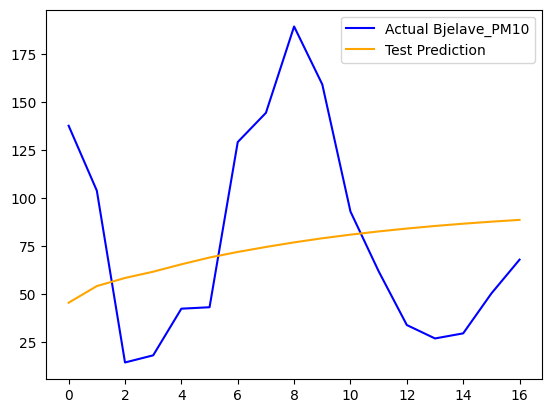

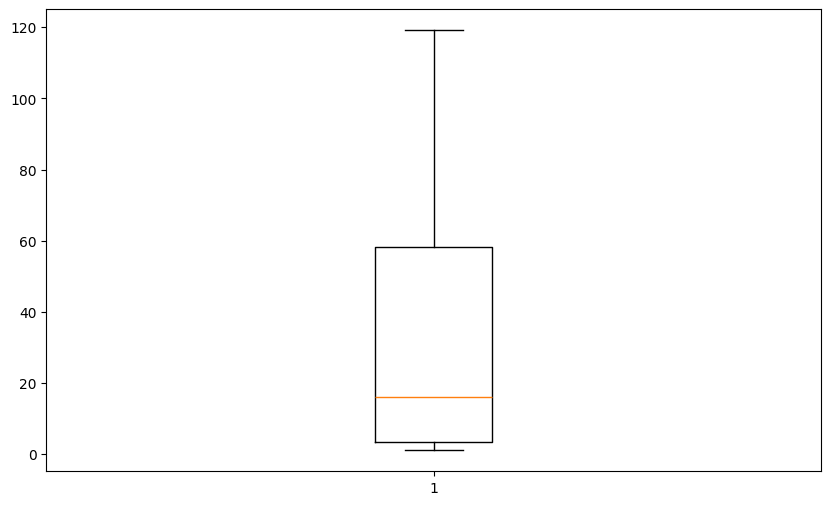

In [ ]:
plt.plot(y_test_PM10_daily_ws_fifteen_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_fifteen, walk_forward_predictions_unscaled[0])

**30 Day Prediction Window**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.0077 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0877
Epoch 2/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0404 - root_mean_squared_error: 0.0719
Epoch 3/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0065 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0803
Epoch 4/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0390 - root_mean_squared_error: 0.0739
Epoch 5/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0705
Epoch 6/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0043 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0652
Epoch 7/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0044 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0659
Epoch 8/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0040 - mean_

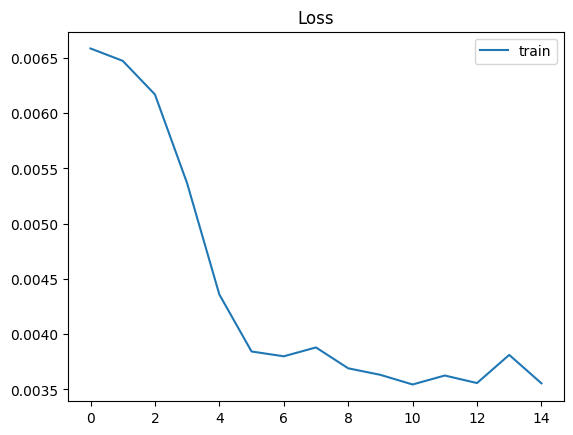

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_thirty, y_train_PM10_daily_ws_thirty)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_thirty_scaled = model.predict(x_test_PM10_daily_ws_thirty)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


In [ ]:
testPredict_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.inverse_transform(testPredict_PM10_daily_ws_thirty_scaled)

In [ ]:
y_test_PM10_daily_ws_thirty_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(y_test_PM10_daily_ws_thirty.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty))
mae = mean_absolute_error(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty)
r2 = r2_score(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)
# previous results:
# RMSE: 36.51894921522029
# MAE: 26.330601179172024
# R2 Score: 0.3554883214703234

RMSE: 35.292092065513145
MAE: 25.777600725201644
R2 Score: 0.381780828229046


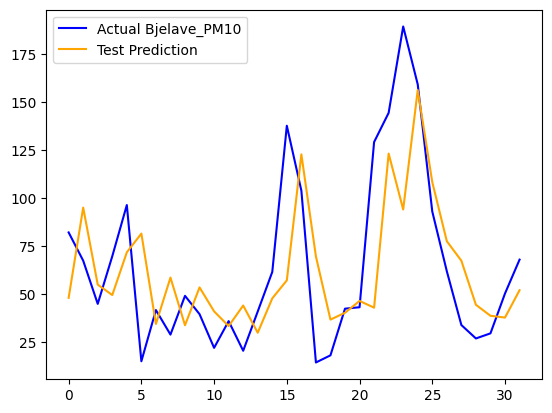

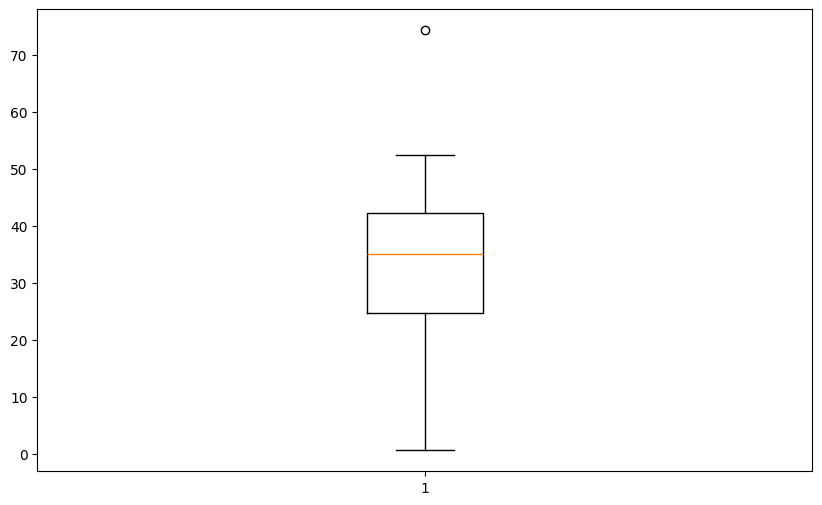

In [ ]:
plt.plot(y_test_PM10_daily_ws_thirty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_thirty, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_thirty, y_test_PM10_daily_ws_thirty_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_thirty[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_thirty)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)
# previous results:
# RMSE: 50.21773309961082
# MAE: 32.88232332502168
# R2 Score: -0.21873267183859202

RMSE: 47.319057913391525
MAE: 34.910178345648326
R2 Score: -0.11137299850684368


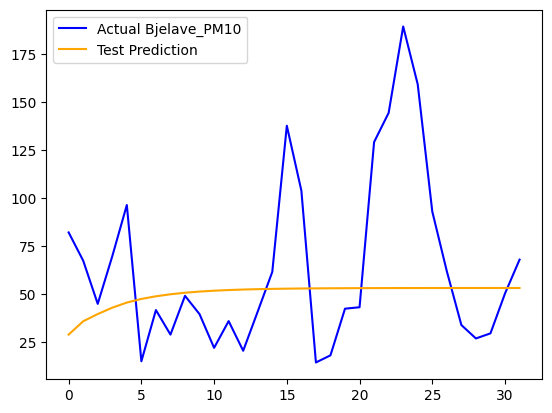

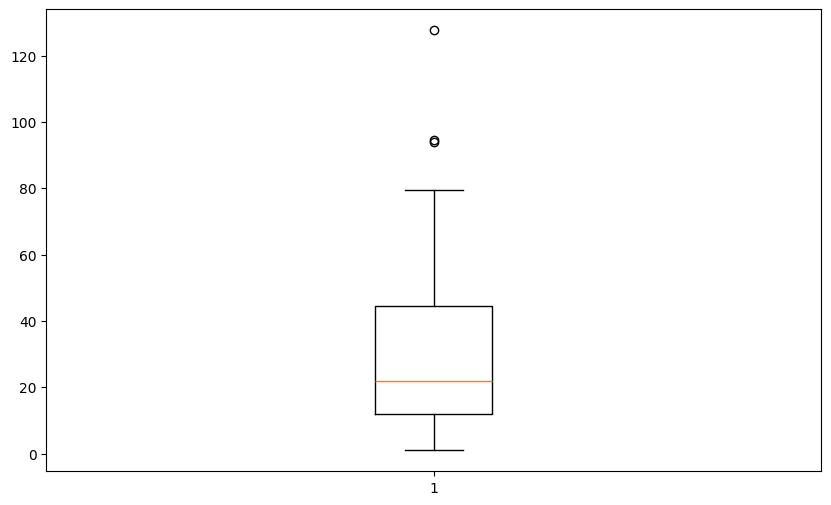

In [ ]:
plt.plot(y_test_PM10_daily_ws_thirty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_thirty, walk_forward_predictions_unscaled[0])

**60-Day Prediction Window**

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0061 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0774
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0070 - mean_absolute_error: 0.0458 - root_mean_squared_error: 0.0831
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0077 - mean_absolute_error: 0.0470 - root_mean_squared_error: 0.0865
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0704
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0052 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0722
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0043 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0655
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0590
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0042 - mean_absolute_e

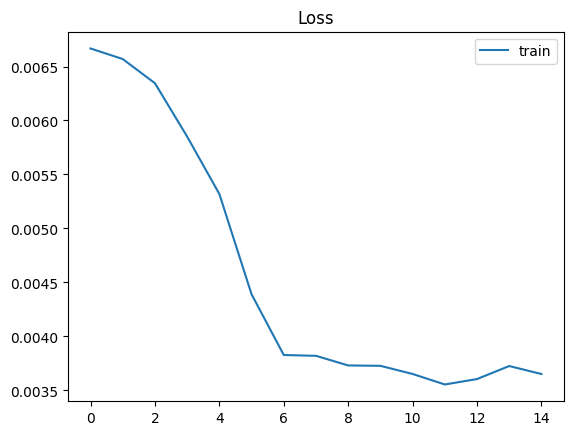

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_sixty, y_train_PM10_daily_ws_sixty)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_77 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_sixty_scaled = model.predict(x_test_PM10_daily_ws_sixty)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [ ]:
testPredict_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.inverse_transform(testPredict_PM10_daily_ws_sixty_scaled)

In [ ]:
y_test_PM10_daily_ws_sixty_unscaled = scaler_PM10_daily_ws_sixty.inverse_transform(y_test_PM10_daily_ws_sixty.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty))
mae = mean_absolute_error(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty)
r2 = r2_score(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 31.869953194363607
MAE: 23.31689229557772
R2 Score: 0.33228044171357674


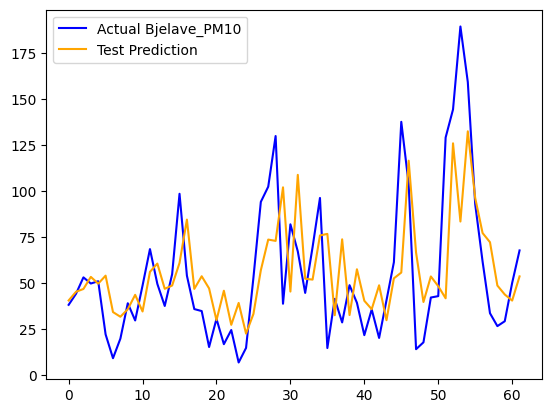

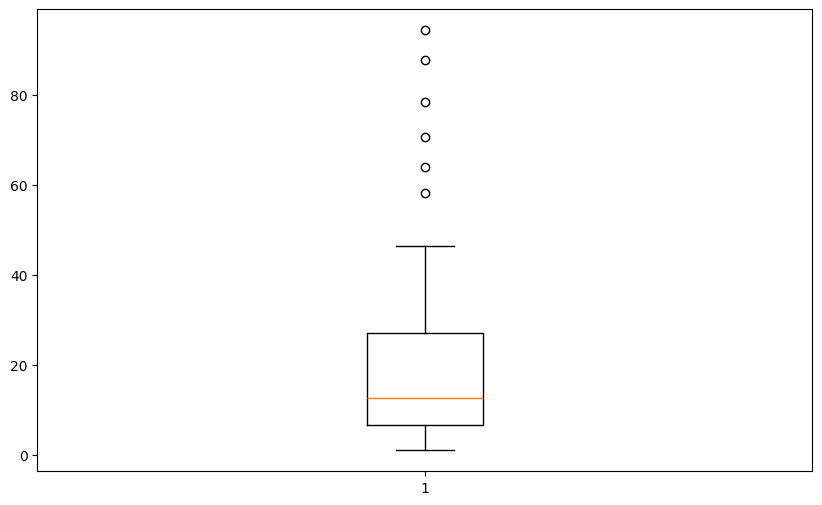

In [ ]:
plt.plot(y_test_PM10_daily_ws_sixty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_sixty, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_sixty, y_test_PM10_daily_ws_sixty_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_sixty[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_sixty)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_sixty.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 38.99687280741869
MAE: 29.749649069464862
R2 Score: 0.00025138750944209143


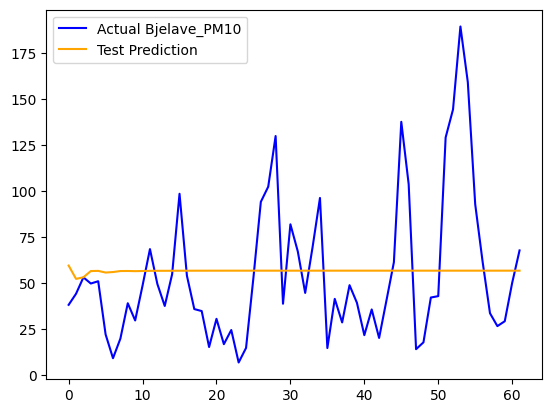

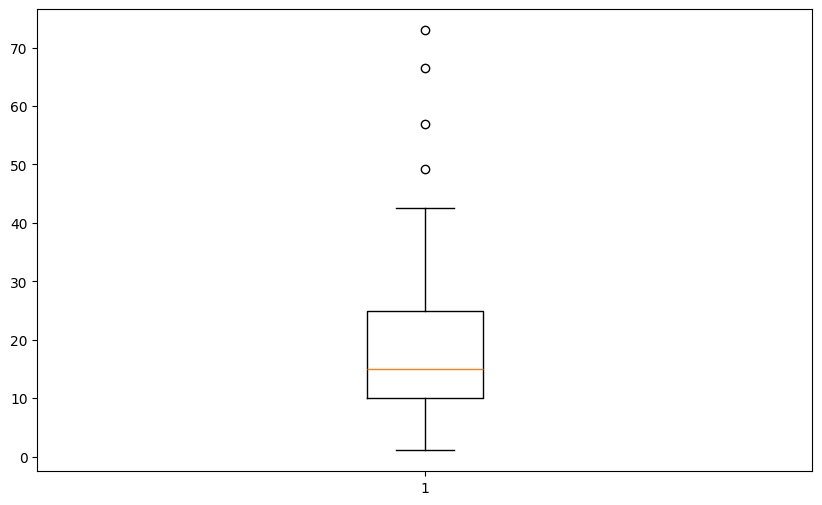

In [ ]:
plt.plot(y_test_PM10_daily_ws_sixty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_sixty, walk_forward_predictions_unscaled[0])

# LSTM for Direct Multi-step Time Series Prediction

In [390]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_training_dataset(data, target_column_index, look_back=3, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), target_column_index])
    return np.array(X), np.array(Y)

def train_multivariate_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    # x_val = x_train[-50:]
    # y_val = y_train[-50:]
    # x_train = x_train[:-50]
    # y_train = y_train[:-50]
    # history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])
    history = model.fit(x_train, y_train, epochs=20, batch_size=6, verbose=1, callbacks=[early_stop])
    return history

def denormalize_prediction(prediction, scaler, target_column_index, num_features):
    full_data = np.zeros((len(prediction), num_features))
    full_data[:, target_column_index] = prediction
    denormalized = scaler.inverse_transform(full_data)
    return denormalized[:, target_column_index]

def evaluate_forecasts(actual_data, predicted_data):
  rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))
  mae = mean_absolute_error(actual_data, predicted_data)
  r2 = r2_score(actual_data, predicted_data)
  print("RMSE:", rmse)
  print("MAE:", mae)
  print("R2 Score:", r2)
  return rmse, mae, r2

In [391]:

def build_multivariate_multistep_model(look_back, num_features, params):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units2"], return_sequences=True))
	model.add(LSTM(units=params["lstm_units1"], return_sequences=False))
	model.add(Dense(params["horizon"]))
	model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [392]:
params_mv = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
  "dropout": 0.2,
	"lstm_units": 70,
	"lstm_units3": 95,
	"lstm_units2": 90,
	"lstm_units1": 50,
	"lstm_units0": 35,
  "horizon": 7
}

In [315]:
#train_data_combined_ws_week = train_data_combined_ws_week.set_index('DateTime')
#test_data_combined_ws_week = test_data_combined_ws_week.set_index('DateTime')

#scaler_data_combined_ws_week = MinMaxScaler(feature_range=(0,1))
#train_data_combined_ws_week_scaled = scaler_data_combined_ws_week.fit_transform(train_data_combined_ws_week)
#test_data_combined_ws_week_scaled = scaler_data_combined_ws_week.transform(test_data_combined_ws_week)

In [316]:
test_data_combined_ws_week_scaled.shape

(17, 11)

In [393]:
params_mv['horizon'] = 7
horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
look_back=horizon
num_features = train_data_combined_ws_week_scaled.shape[1]
X_train_ws_week, Y_train_ws_week = create_training_dataset(
    train_data_combined_ws_week_scaled,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_week shape: {X_train_ws_week.shape}")
print(f"Y_train_ws_week shape: {Y_train_ws_week.shape}")

X_train_ws_week shape: (1796, 7, 11)
Y_train_ws_week shape: (1796, 7)


**7-Day Prediction Window**

In [318]:
#model_week_multivariate = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

In [319]:
#model_week_multivariate.summary()

In [320]:
#history_week_multivariate = train_multivariate_model(model_week_multivariate, X_train_ws_week, Y_train_ws_week)
#plot_loss(history_week_multivariate)

In [321]:
##last_sequence = train_data_combined_ws_week_scaled[-look_back:].reshape(1, look_back, num_features)
#print(f"Last sequence shape: {last_sequence.shape}")

In [322]:
#prediction_ws_week = model_week_multivariate.predict(last_sequence, verbose=0)
#print(f"Raw prediction shape: {prediction_ws_week.shape}")  # (1, 7)
#print(f"Raw prediction values: {prediction_ws_week}")

In [323]:
#prediction_denormalized_ws_week = denormalize_prediction(
  #  prediction_ws_week.flatten(),
  #  scaler_data_combined_ws_week,
  #  index_of_target_feature,
  #  num_features
#)

In [324]:
#print(f"Denormalized prediction for next 7 days: {prediction_denormalized_ws_week}")


In [325]:
#last_date = train_data_combined_ws_week.index[-1]
#prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')


In [326]:
#prediction_denormalized_ws_week

In [327]:
#prediction_df_ws_week = pd.DataFrame({
 #   'DateTime': prediction_dates,
 #   'Bjelave_PM10': prediction_denormalized_ws_week
#})
#print("\nPrediction results:")
#print(prediction_df_ws_week)

In [328]:
#df_test_data_combined_ws_week = test_data_combined_ws_week['Bjelave_PM10'][:7].reset_index()
#df_test_data_combined_ws_week

In [329]:
#prediction_df_ws_week

In [330]:
#(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(df_test_data_combined_ws_week['Bjelave_PM10'], prediction_df_ws_week['Bjelave_PM10'])
#RMSE: 21.074179449811325
#MAE: 18.621930656128665
#R2 Score: -3.6714691113690705


In [331]:
#plt.plot(df_test_data_combined_ws_week['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
#plt.plot(prediction_df_ws_week['Bjelave_PM10'], label='Test Prediction', color='orange')
#plt.legend()
#plt.show()

#plot_boxplot(prediction_df_ws_week['Bjelave_PM10'], df_test_data_combined_ws_week['Bjelave_PM10'][0])

**7-Day Prediction Window (with time features)**

In [332]:
#params_mv['horizon'] = 7
#horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
#look_back=horizon + int(params_mv['horizon']/5 + 1)
#num_features = train_data_combined_ws_week_scaled_dt.shape[1]
#X_train_ws_week_dt, Y_train_ws_week_dt = create_training_dataset(
 #   train_data_combined_ws_week_scaled_dt,
  #  index_of_target_feature,
   # look_back=look_back,
    #horizon=params_mv['horizon']
#)
#print(f"X_train_ws_week_dt shape: {X_train_ws_week_dt.shape}")
#print(f"Y_train_ws_week_dt shape: {Y_train_ws_week_dt.shape}")

In [333]:
#params_mv['horizon']=7

In [334]:
#model_week_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

In [335]:
#model_week_multivariate_dt.summary()

In [336]:
#history_week_multivariate_dt = train_multivariate_model(model_week_multivariate_dt, X_train_ws_week_dt, Y_train_ws_week_dt)
#plot_loss(history_week_multivariate_dt)

In [337]:
#last_sequence_dt = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
#print(f"Last sequence shape: {last_sequence.shape}")

In [338]:
#prediction_ws_week_dt = model_week_multivariate_dt.predict(last_sequence_dt, verbose=0)
#print(f"Raw prediction shape: {prediction_ws_week_dt.shape}")  # (1, 7)
#print(f"Raw prediction values: {prediction_ws_week_dt}")

In [339]:
#prediction_denormalized_ws_week_dt = denormalize_prediction(
  #  prediction_ws_week_dt.flatten(),
  #  scaler_data_combined_ws_week_dt,
  #  index_of_target_feature,
  #  num_features
#)
#print(f"Denormalized prediction for next 7 days: {prediction_denormalized_ws_week_dt}")

In [340]:
#last_date = train_data_combined_ws_week.index[-1]
#prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')

In [341]:
#prediction_dates.shape

In [342]:
#prediction_denormalized_ws_week_dt.shape

In [343]:
#last_date = train_data_combined_ws_week_dt.index[-1]
#prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
#prediction_ws_week_dt = pd.DataFrame({
 #   'DateTime': prediction_dates,
 #   'Bjelave_PM10': prediction_denormalized_ws_week_dt
#})
#print("\nPrediction results:")
#print(prediction_ws_week_dt)
#print("\nActual results:")
#df_test_data_combined_ws_week_dt = test_data_combined_ws_week_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
#print(df_test_data_combined_ws_week_dt)

In [344]:
#(rmse_ws_week_dt, mae_ws_week_dt, r2_ws_week_dt) = evaluate_forecasts(df_test_data_combined_ws_week_dt['Bjelave_PM10'], prediction_ws_week_dt['Bjelave_PM10'])
#RMSE: 11.38436025721496
#MAE: 9.263917115022199
#R2 Score: -0.3632308164224769

In [345]:
#plt.plot(df_test_data_combined_ws_week_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
#plt.plot(prediction_ws_week_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
#plt.legend()
#plt.show()

#plot_boxplot(prediction_ws_week_dt['Bjelave_PM10'], df_test_data_combined_ws_week_dt['Bjelave_PM10'][0])

**15-Day Prediction Window (with time features)**

In [346]:
#params_mv['horizon'] =15
#horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
#look_back=horizon + int(params_mv['horizon']/5 + 1)
#num_features = train_data_combined_ws_fifteen_scaled_dt.shape[1]
#X_train_ws_fifteen_dt, Y_train_ws_fifteen_dt = create_training_dataset(
  #  train_data_combined_ws_fifteen_scaled_dt,
  #  index_of_target_feature,
  #  look_back=look_back,
  #  horizon=horizon
#)
#print(f"X_train_ws_fifteen_dt shape: {X_train_ws_fifteen_dt.shape}")
#print(f"Y_train_ws_fifteen_dt shape: {Y_train_ws_fifteen_dt.shape}")

In [347]:
#params_mv['horizon'] = 15

In [348]:
#model_fifteen_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

In [349]:
#model_fifteen_multivariate_dt.summary()

In [350]:
#history_fifteen_multivariate_dt = train_multivariate_model(model_fifteen_multivariate_dt, X_train_ws_fifteen_dt, Y_train_ws_fifteen_dt)
#plot_loss(history_fifteen_multivariate_dt)

In [351]:
#last_sequence_dt = train_data_combined_ws_fifteen_scaled_dt[-look_back:].reshape(1, look_back, num_features)
#print(f"Last sequence shape: {last_sequence_dt.shape}")

In [352]:
#prediction_ws_fifteen_dt = model_fifteen_multivariate_dt.predict(last_sequence_dt, verbose=0)
#print(f"Raw prediction shape: {prediction_ws_fifteen_dt.shape}")
#print(f"Raw prediction values: {prediction_ws_fifteen_dt}")

In [353]:
#prediction_denormalized_ws_fifteen_dt = denormalize_prediction(
   # prediction_ws_fifteen_dt.flatten(),
   # scaler_data_combined_ws_fifteen_dt,
   # index_of_target_feature,
   # num_features
#)
#print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_fifteen_dt}")

In [354]:
#last_date = train_data_combined_ws_fifteen_dt.index[-1]
#prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
#prediction_ws_fifteen_dt = pd.DataFrame({
 #   'DateTime': prediction_dates,
 #   'Bjelave_PM10': prediction_denormalized_ws_fifteen_dt
#})
#print("\nPrediction results:")
#print(prediction_ws_fifteen_dt)
#print("\nActual results:")
#df_test_data_combined_ws_fifteen_dt = test_data_combined_ws_fifteen_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
#print(df_test_data_combined_ws_fifteen_dt)

In [355]:
#(rmse_ws_fifteen_dt, mae_ws_fifteen_dt, r2_ws_fifteen_dt) = evaluate_forecasts(df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'], prediction_ws_fifteen_dt['Bjelave_PM10'])
#RMSE: 34.015821129083534
#MAE: 28.18273639009225
#R2 Score: 0.10498566377503904

In [356]:
#plt.plot(df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
#plt.plot(prediction_ws_fifteen_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
#plt.legend()
#plt.show()

#plot_boxplot(prediction_ws_fifteen_dt['Bjelave_PM10'], df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'][0])

**30-Day Prediction Window (with time features)**

In [394]:
params_mv['horizon'] = 30
horizon = params_mv['horizon']
#look_back=horizon
look_back=horizon + int(params_mv['horizon']/6 + 1)
num_features = train_data_combined_ws_thirty_scaled_dt.shape[1]
X_train_ws_thirty_dt, Y_train_ws_thirty_dt = create_training_dataset(
    train_data_combined_ws_thirty_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_thirty_dt shape: {X_train_ws_thirty_dt.shape}")
print(f"Y_train_ws_thirty_dt shape: {Y_train_ws_thirty_dt.shape}")

X_train_ws_thirty_dt shape: (1693, 36, 14)
Y_train_ws_thirty_dt shape: (1693, 30)


In [395]:
model_thirty_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)
model_thirty_multivariate_dt.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 36, 70)         │        23,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 36, 70)         │        39,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 36, 70)         │        39,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 50)             │        24,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,490 (501.91 KB)

 Trainable params: 128,490 (501.91 KB)

 Non-trainable params: 0 (0.00 B)

In [396]:
history_thirty_multivariate_dt = train_multivariate_model(model_thirty_multivariate_dt, X_train_ws_thirty_dt, Y_train_ws_thirty_dt)
plot_loss(history_thirty_multivariate_dt)

Epoch 1/20


LookupError: gradient registry has no entry for: shap_DivNoNan

In [ ]:
last_sequence_dt = test_data_combined_ws_thirty_scaled_dt[:look_back].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence_dt.shape}")

In [ ]:
prediction_ws_thirty_dt = model_thirty_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_thirty_dt.shape}")
print(f"Raw prediction values: {prediction_ws_thirty_dt}")

In [ ]:
prediction_denormalized_ws_thirty_dt = denormalize_prediction(
    prediction_ws_thirty_dt.flatten(),
    scaler_data_combined_ws_thirty_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_thirty_dt}")

In [ ]:
test_data_combined_ws_ninety_dt.shape

In [ ]:
last_date = test_data_combined_ws_thirty_dt.index[look_back]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_thirty_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_thirty_dt
})
print("\nPrediction results:")
print(prediction_ws_thirty_dt)
print("\nActual results:")
df_test_data_combined_ws_thirty_dt = test_data_combined_ws_thirty_dt['Bjelave_PM10'][look_back:look_back + params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_thirty_dt)

In [ ]:
(rmse_ws_thirty_dt, mae_ws_thirty_dt, r2_ws_thirty_dt) = evaluate_forecasts(df_test_data_combined_ws_thirty_dt['Bjelave_PM10'], prediction_ws_thirty_dt['Bjelave_PM10'])
"""
RMSE: 39.90348575818405
MAE: 33.11183869159841
R2 Score: 0.25515581438332535

"""

In [ ]:
plt.plot(df_test_data_combined_ws_thirty_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_thirty_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_thirty_dt['Bjelave_PM10'], df_test_data_combined_ws_thirty_dt['Bjelave_PM10'][0])

**60-Day Prediction Window (with time features)**

In [ ]:
params_mv['horizon'] = 60
horizon = params_mv['horizon']
look_back=horizon + int(params_mv['horizon']/6 + 1)
#look_back=horizon
num_features = train_data_combined_ws_sixty_scaled_dt.shape[1]
X_train_ws_sixty_dt, Y_train_ws_sixty_dt = create_training_dataset(
    train_data_combined_ws_sixty_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train shape: {X_train_ws_sixty_dt.shape}")
print(f"Y_train shape: {Y_train_ws_sixty_dt.shape}")

In [ ]:
look_back

In [ ]:
model_sixty_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)
model_sixty_multivariate_dt.summary()

In [ ]:
history_sixty_multivariate_dt = train_multivariate_model(model_sixty_multivariate_dt, X_train_ws_sixty_dt, Y_train_ws_sixty_dt)
plot_loss(history_sixty_multivariate_dt)

In [ ]:
last_sequence_dt = test_data_combined_ws_sixty_scaled_dt[:look_back].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence_dt.shape}")

In [ ]:
prediction_ws_sixty_dt = model_sixty_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_sixty_dt.shape}")
print(f"Raw prediction values: {prediction_ws_sixty_dt}")

In [ ]:
prediction_denormalized_ws_sixty_dt = denormalize_prediction(
    prediction_ws_sixty_dt.flatten(),
    scaler_data_combined_ws_sixty_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_sixty_dt}")

In [ ]:
prediction_denormalized_ws_sixty_dt.shape

In [ ]:
test_data_combined_ws_sixty_dt.shape[0]-look_back

In [ ]:
last_date = test_data_combined_ws_sixty_dt.index[look_back]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_sixty_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_sixty_dt
})
print("\nPrediction results:")
print(prediction_ws_thirty_dt)
print("\nActual results:")
df_test_data_combined_ws_sixty_dt = test_data_combined_ws_sixty_dt['Bjelave_PM10'][look_back:look_back + params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_sixty_dt)

In [ ]:
(rmse_ws_sixty_dt, mae_ws_sixty_dt, r2_ws_sixty_dt) = evaluate_forecasts(df_test_data_combined_ws_sixty_dt['Bjelave_PM10'], prediction_ws_sixty_dt['Bjelave_PM10'])
"""
RMSE: 11.961889153079229
MAE: 9.526326950984705
R2 Score: 0.2611057693273542
"""


In [ ]:
plt.plot(df_test_data_combined_ws_sixty_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_sixty_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_sixty_dt['Bjelave_PM10'], df_test_data_combined_ws_sixty_dt['Bjelave_PM10'][0])

**90-Day Prediction Window (with time features)**

In [ ]:
params_mv['horizon'] = 90
horizon = params_mv['horizon']
look_back=horizon + int(params_mv['horizon']/6 + 1)
#look_back=horizon
num_features = train_data_combined_ws_ninety_scaled_dt.shape[1]
X_train_ws_ninety_dt, Y_train_ws_ninety_dt = create_training_dataset(
    train_data_combined_ws_ninety_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_ninety_dt shape: {X_train_ws_ninety_dt.shape}")
print(f"Y_train_ws_ninety_dt shape: {Y_train_ws_ninety_dt.shape}")

In [ ]:
model_ninety_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)
model_ninety_multivariate_dt.summary()

In [ ]:
history_ninety_multivariate_dt = train_multivariate_model(model_ninety_multivariate_dt, X_train_ws_ninety_dt, Y_train_ws_ninety_dt)
plot_loss(history_ninety_multivariate_dt)

In [ ]:
train_data_combined_ws_ninety_scaled

In [ ]:
look_back

In [ ]:
90+int(90/6 +1)

In [ ]:
test_data_combined_ws_ninety_scaled_dt.shape

In [ ]:
last_sequence = test_data_combined_ws_ninety_scaled_dt[:look_back].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence.shape}")

In [ ]:
prediction_ws_ninety_dt = model_ninety_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_ninety_dt.shape}")
print(f"Raw prediction values: {prediction_ws_ninety_dt}")

In [ ]:
prediction_denormalized_ws_ninety_dt = denormalize_prediction(
    prediction_ws_ninety_dt.flatten(),
    scaler_data_combined_ws_ninety_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_ninety_dt}")

In [ ]:
last_date = test_data_combined_ws_ninety_dt.index[look_back]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_ninety_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_ninety_dt
})
print("\nPrediction results:")
print(prediction_ws_ninety_dt)
print("\nActual results:")
df_test_data_combined_ws_ninety_dt = test_data_combined_ws_ninety_dt['Bjelave_PM10'][look_back:look_back + params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_ninety_dt)

In [ ]:
(rmse_ws_ninety_dt, mae_ws_ninety_dt, r2_ws_ninety_dt) = evaluate_forecasts(df_test_data_combined_ws_ninety_dt['Bjelave_PM10'], prediction_ws_ninety_dt['Bjelave_PM10'])

In [ ]:
plt.plot(df_test_data_combined_ws_ninety_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_ninety_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_ninety_dt['Bjelave_PM10'], df_test_data_combined_ws_ninety_dt['Bjelave_PM10'][0])

# LSTM for Multivariate Multi-step Time Series Prediction

In [ ]:
params_mv = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "lstm_units": 64,
    "lstm_units1": 60,
    "horizon": 7,
		"look_back": 15
}
num_features=train_data_combined_ws_week_dt.shape[1]


NameError: name 'train_data_combined_ws_week_dt' is not defined

In [ ]:
def build_multivariate_multistep_model(look_back, num_features, params):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units1"], return_sequences=False))

    model.add(Dense(params["horizon"] * num_features))
    model.add(Reshape((params["horizon"], num_features)))

    model.compile(
        loss=params["loss"],
        optimizer=params["optimizer"],
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
    )
    return model

In [ ]:
def create_full_multivariate_dataset(data, look_back=30, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), :])
    return np.array(X), np.array(Y)

In [ ]:
def train_multivariate_model(model, x_train, y_train):

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=15,
        batch_size=5,
        verbose=1,
        callbacks=[early_stop]
    )
    return history

In [ ]:
def create_full_multivariate_dataset(data, look_back=30, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), :])
    return np.array(X), np.array(Y)

def train_multivariate_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=25,
        batch_size=15,
        verbose=1,
        callbacks=[early_stop]
    )
    return history


In [ ]:
X_train_ws_week, Y_train_ws_week = create_full_multivariate_dataset(
    train_data_combined_ws_week_scaled_dt,
    look_back=params_mv["look_back"],
    horizon=params_mv["horizon"]
)
print(f"X_train_ws_week.shape: {X_train_ws_week.shape}")
print(f"Y_train_ws_week.shape: {Y_train_ws_week.shape}")
params_mv["target_col_idx"] = index_of_target_feature
params_mv["target_weight"] = 3.0

X_train_ws_week.shape: (1779, 15, 14)
Y_train_ws_week.shape: (1779, 7, 14)


In [ ]:
model_week_multivariate = build_multivariate_multistep_model(params_mv["look_back"], num_features, params=params_mv)
model_week_multivariate.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_161 (LSTM)                 │ (None, 15, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_162 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_163 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_164 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_165 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_166 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_167 (LSTM)                 │ (None, 60)             │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 98)             │         5,978 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 7, 14)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,322 (864.54 KB)

 Trainable params: 221,322 (864.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1064 - mean_absolute_error: 0.2347 - root_mean_squared_error: 0.3183
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0441 - mean_absolute_error: 0.1510 - root_mean_squared_error: 0.2101
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0442 - mean_absolute_error: 0.1512 - root_mean_squared_error: 0.2102
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0365 - mean_absolute_error: 0.1374 - root_mean_squared_error: 0.1911
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0349 - mean_absolute_error: 0.1324 - root_mean_squared_error: 0.1867
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0313 - mean_absolute_error: 0.1242 - root_mean_squared_error: 0.1769
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0302 - mean_absolute_error: 0.1208 - root_mean_squared_error: 0.1738
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0262 - mean_a

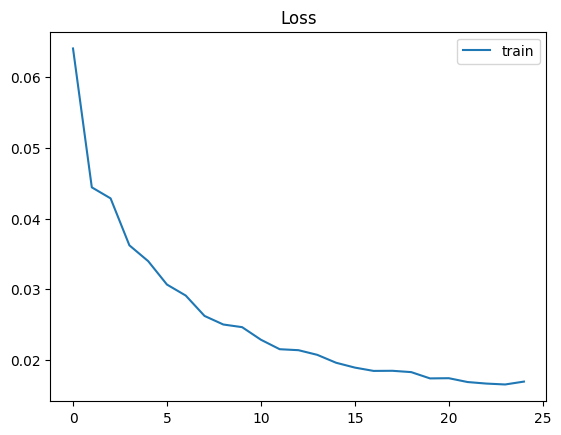

In [ ]:
history_week_multivariate = train_multivariate_model(
    model_week_multivariate,
    X_train_ws_week,
    Y_train_ws_week
)

plot_loss(history_week_multivariate)

In [ ]:
last_sequence = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
prediction_all_vars = model_week_multivariate.predict(last_sequence, verbose=0)

In [ ]:
target_predictions = prediction_all_vars[0, :, index_of_target_feature]

prediction_denormalized_ws_week = denormalize_prediction(
    target_predictions,
    scaler_data_combined_ws_week_dt,
    index_of_target_feature,
    num_features
)
prediction_df_ws_week = pd.DataFrame({
    'Bjelave_PM10': prediction_denormalized_ws_week
})
print("\nPrediction results:")
print(prediction_df_ws_week)

print("\nActual results:")
df_test_data_combined_ws_week_dt = test_data_combined_ws_week_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_week_dt)


Prediction results:
   Bjelave_PM10
0     34.352286
1     38.309806
2     42.413692
3     56.629995
4     44.812148
5     68.064703
6     63.905331

Actual results:
    DateTime  Bjelave_PM10
0 2022-12-06     28.723416
1 2022-12-07     48.954487
2 2022-12-08     39.391658
3 2022-12-09     21.807971
4 2022-12-10     35.767727
5 2022-12-11     20.287982
6 2022-12-12     40.775529


RMSE: 24.68690726498166
MAE: 19.15265014216846
R2 Score: -5.410405542316653


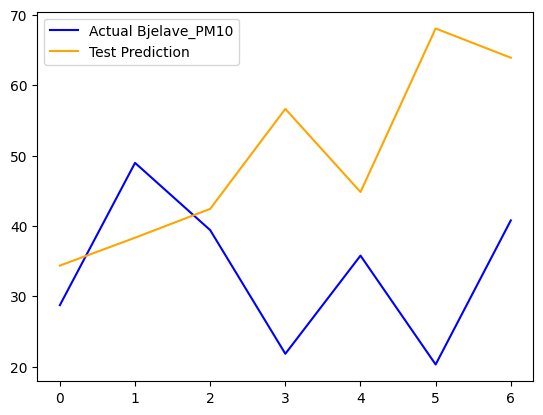

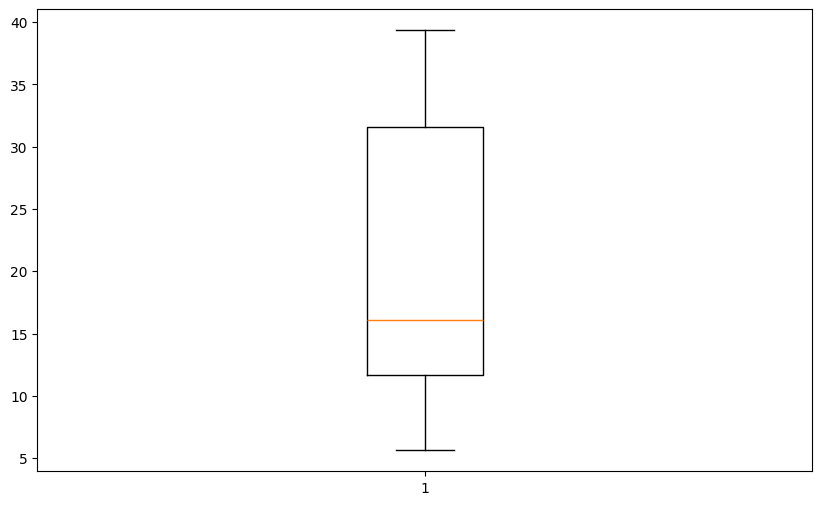

In [ ]:
(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(df_test_data_combined_ws_week_dt['Bjelave_PM10'], prediction_df_ws_week['Bjelave_PM10'])

plt.plot(df_test_data_combined_ws_week_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_df_ws_week['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_df_ws_week['Bjelave_PM10'], df_test_data_combined_ws_week_dt['Bjelave_PM10'][0])

# LSTM for Multivariate One-step Time Series Prediction

In [ ]:
# za sada jako losa predikcija, nema smisla korisiti za duze periode

In [ ]:
num_features=train_data_combined_ws_week_scaled_dt.shape[1]

In [ ]:
def build_simple_model(look_back, num_features, params):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units1"], return_sequences=False))

    model.add(Dense(num_features))

    model.compile(
        loss=params["loss"],
        optimizer=params["optimizer"],
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
    )
    return model

In [ ]:
def create_one_day_dataset(data, look_back=30):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, :])
    return np.array(X), np.array(Y)


In [ ]:
X_train, Y_train = create_one_day_dataset(
    train_data_combined_ws_week_scaled_dt,
    look_back=look_back
)
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")


X_train shape: (1770, 30, 14)
Y_train shape: (1770, 14)


In [ ]:
params_simple = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "lstm_units": 200,
    "lstm_units1": 170
}

In [ ]:
model = build_simple_model(look_back, num_features, params_simple)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                 │ (None, 30, 200)        │       172,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_127 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_132 (LSTM)                 │ (None, 170)            │       252,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 14)             │         2,394 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,030,674 (7.75 MB)

 Trainable params: 2,030,674 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def train_simple_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=18,
        batch_size=10,
        verbose=1,
        callbacks=[early_stop]
    )
    return history


Epoch 1/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0600 - mean_absolute_error: 0.1710 - root_mean_squared_error: 0.2396
Epoch 2/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0296 - mean_absolute_error: 0.1184 - root_mean_squared_error: 0.1721
Epoch 3/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0278 - mean_absolute_error: 0.1144 - root_mean_squared_error: 0.1667
Epoch 4/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0266 - mean_absolute_error: 0.1099 - root_mean_squared_error: 0.1630
Epoch 5/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0245 - mean_absolute_error: 0.1069 - root_mean_squared_error: 0.1566
Epoch 6/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0228 - mean_absolute_error: 0.1012 - root_mean_squared_error: 0.1511
Epoch 7/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0223 - mean_absolute_error: 0.1001 - root_mean_squared_error: 0.1493
Epoch 8/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0210 - mean_a

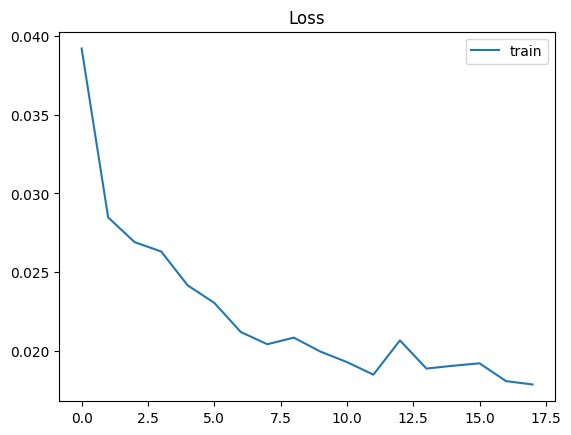

In [ ]:
history = train_simple_model(model, X_train, Y_train)
plot_loss(history)

In [ ]:
last_sequence = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
prediction = model.predict(last_sequence, verbose=0)

print(f"Prediction shape: {prediction.shape}")  # (1, features)
print(f"Prediction values: {prediction[0]}")

Prediction shape: (1, 14)
Prediction values: [0.15274656 0.48350808 0.07116527 0.47158864 0.35313505 0.8592758
 0.47835132 0.7553521  0.09293988 0.1059448  0.25958893 0.2589707
 0.90913707 0.84980243]


In [ ]:
prediction_denormalized = scaler_data_combined_ws_week_dt.inverse_transform(prediction)
print(f"Denormalized prediction: {prediction_denormalized[0]}")

Denormalized prediction: [1.1915576e+00 1.9274013e+02 2.4255496e-01 9.4141870e+02 3.9061642e+00
 8.9105606e+01 9.7000469e+03 6.0428166e+00 4.7192150e+01 1.8195061e+01
 2.8947556e+01 8.7691212e+00 1.1000507e+01 2.0213992e+03]


In [ ]:
prediction_denormalized[0][8]

np.float32(47.19215)

In [ ]:
target_prediction = prediction_denormalized[0, index_of_target_feature]
print(f"Target prediction (1 day): {target_prediction}")

Target prediction (1 day): 47.1921501159668


In [ ]:
test_data_combined_ws_week_dt.iloc[0]

,2022-12-06
wind_speed,1.700000
wind_direction,144.458333
precipitation,0.508333
pressure,941.104167
temperature,7.525000
humidity,84.416667
visibility,14489.166667
cloudiness,7.416667
Bjelave_PM10,28.723416
Bjelave_SO2,18.977879
